# 构建一个学习算法的总体架构

## 1-导入所需的包 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
# from scipy import ndimage
from skimage.transform import resize
from lr_utils import load_dataset  # 此乃官方提供的获取数据集的模块
# 用来控制matplotlib画图的
% matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 加载数据（猫/非猫）
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
# train_set_x_orig 和 test_set_x_orig中的每一行是一个表示图像的数组
print(train_set_x_orig.shape)
print(train_set_x_orig[1])

(209, 64, 64, 3)
[[[196 192 190]
  [193 186 182]
  [188 179 174]
  ...
  [ 90 142 200]
  [ 90 142 201]
  [ 90 142 201]]

 [[230 229 229]
  [204 199 197]
  [193 186 181]
  ...
  [ 91 143 201]
  [ 91 143 201]
  [ 91 143 201]]

 [[232 225 224]
  [235 234 234]
  [208 205 202]
  ...
  [ 91 144 202]
  [ 91 144 202]
  [ 92 144 202]]

 ...

 [[ 18  17  15]
  [ 14  14  13]
  [ 29  29  32]
  ...
  [ 83  81  81]
  [ 84  82  83]
  [ 82  81  82]]

 [[ 22  20  18]
  [ 16  15  14]
  [ 25  24  24]
  ...
  [ 82  80  80]
  [ 83  81  82]
  [ 82  81  81]]

 [[ 45  43  39]
  [ 61  59  54]
  [ 81  78  74]
  ...
  [ 83  82  81]
  [ 84  82  82]
  [ 82  80  81]]]


y = [1], it's a 'cat' picture.


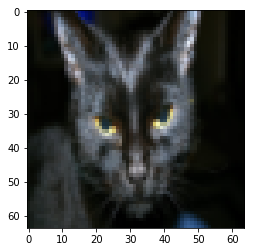

In [3]:
# 图片的例子
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

## 2.对数据集进行操作

In [4]:
# m_train(训练集的数量)
# m_test(测试集的数量)
# num_px(训练集图片的宽高)
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]
###
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print('test_set_y is',str(test_set_y))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
test_set_y is [[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


In [5]:
# 将数据集的数组转换为numpy的矩阵
train_set_x_flatten=train_set_x_orig.reshape(m_train,-1).T  # 此处reshape中的-1表示让numpy自动计算可以重构成一个多少列的矩阵
test_set_x_flatten=test_set_x_orig.reshape(m_test,-1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [6]:
# 标准化数据集
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255

In [7]:
# 这里每一列代表一张图片的64×64×3的一组特征向量，共有209列
print(train_set_x)

[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


## 3.构建一个逻辑回归的模型

- 构建所用到的算法

In [8]:
# sigmoid
def sigmoid(z):
    '''
    Arguments:
    z-- W^Tx+b
    '''
    return 1/(1+np.exp(-z))


In [9]:
sigmoid(np.array([0,2]))

array([0.5       , 0.88079708])

- 初始化参数

In [10]:
# 初始化参数w为一个为0的列矩阵,b=0
# dim应与特征向量的维度相同
def initialize_with_zeros(dim):
    w=np.zeros((dim,1))
    b=0
    return w,b

In [11]:
w,b=initialize_with_zeros(5)
print('w =',w)
print('b =',b)

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


- 正向和反向传播

In [12]:
def propagate(w,b,X,Y):
    m=X.shape[1]  # 数据集数量
    A=sigmoid(np.dot(w.T,X)+b)
    cost=(-1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    # 反向传播
    dw=(1/m)*np.dot(X,(A-Y).T)
    db=(1/m)*np.sum(A-Y)
    
    grads={
           'dw':dw,
           'db':db
          }
    return grads,cost
    

In [13]:
w,b,X,Y=np.array([[1.],[2.]]),2.,np.array([[1.,2.,-1.],[3.,4.,-3.2]]),np.array([[1,0,1]])
grads,cost=propagate(w,b,X,Y)
print('grads:',grads)
print('cost:',cost)

grads: {'dw': array([[0.99845601],
       [2.39507239]]), 'db': 0.001455578136784208}
cost: 5.801545319394553


- 优化参数，梯度下降

In [14]:
def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    costs=[]
    for i in range(num_iterations):
        grads,cost=propagate(w,b,X,Y)
        dw=grads['dw']
        db=grads['db']
        
        # 优化参数的规则
        w=w-learning_rate*dw
        b=b-learning_rate*db
        
        # 记录成本函数结果
        if i%100==0:
            costs.append(cost)
        # 打印成本函数的每一百个数据的结果
        if print_cost and i%100==0:
            print('Cost after iteration %i:%f'%(i,cost))
        params={
            'w':w,
            'b':b
        }
        grads={
            'dw':dw,
            'db':db
        }
    return params,grads,costs

In [15]:
params,grads,costs=optimize(w,b,X,Y,100,0.009,False)
print('w='+str(params['w']))
print('b='+str(params['b']))
print('dw='+str(grads['dw']))
print('db='+str(grads['db']))

w=[[0.19033591]
 [0.12259159]]
b=1.9253598300845747
dw=[[0.67752042]
 [1.41625495]]
db=0.21919450454067657


- 预测结果集

In [16]:
# 预测数据集结果 Y^^
def predict(w,b,X):
    '''
    Arguments:
    w -- 权重矩阵, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Returns:
    Y -- 返回所有数据集对应的结果集，是一个numpy数组
    '''
    m=X.shape[1] # 获取训练集的数量，索引0对应的是每个图片的nx个特征
    Y=np.zeros((1,m)) # 初始化一个全为0的【1，m】的结果集矩阵
    
    w=w.reshape(X.shape[0],1)
    
    # 计算出预测值y帽的【m，1】的矩阵
    A=sigmoid(np.dot(w.T,X)+b)
    for i in range(X.shape[1]):
        if A[0,i]>0.5:
            Y[0,i]=1
        else:
            Y[0,i]=0
    
    return Y

In [17]:
w=np.array([[0.1124579],[0.23106775]])
b=-0.3
X=np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print(X.shape)
print('predictions='+str(predict(w,b,X)))

(2, 3)
predictions=[[1. 1. 0.]]


- 合并以上的所有函数到一个模型中

In [18]:
def model(X_train,Y_train,X_test,Y_test,num_iterations=2000,learning_rate=0.5,print_cost=False):
    # 初始化参数w，b
    w,b=initialize_with_zeros(X_train.shape[0])
    
    # 梯度下降
    parameters,grads,costs=optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # 2000次梯度下降后的w和b参数
    w=parameters['w']
    b=parameters['b']
    
    Y_prediction_test=predict(w,b,X_test)
    Y_prediction_train=predict(w,b,X_train)
    
    # Print Train/Test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d={
        'costs':costs,
        'Y_prediction_test':Y_prediction_test,
        'Y_prediction_train':Y_prediction_train,
        'w':w,
        'b':b,
        'learing_rate':learning_rate,
        'num_iterations':num_iterations
    }
    return d
    

In [19]:
d = d=model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0:0.693147
Cost after iteration 100:0.584508
Cost after iteration 200:0.466949
Cost after iteration 300:0.376007
Cost after iteration 400:0.331463
Cost after iteration 500:0.303273
Cost after iteration 600:0.279880
Cost after iteration 700:0.260042
Cost after iteration 800:0.242941
Cost after iteration 900:0.228004
Cost after iteration 1000:0.214820
Cost after iteration 1100:0.203078
Cost after iteration 1200:0.192544
Cost after iteration 1300:0.183033
Cost after iteration 1400:0.174399
Cost after iteration 1500:0.166521
Cost after iteration 1600:0.159305
Cost after iteration 1700:0.152667
Cost after iteration 1800:0.146542
Cost after iteration 1900:0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


In [20]:
print(d)

{'Y_prediction_test': array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0.]]), 'Y_prediction_train': array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
 

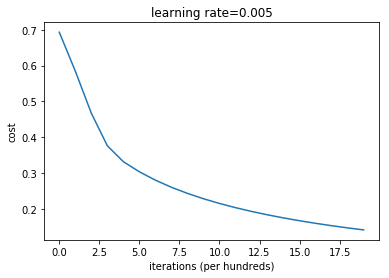

In [21]:
# plot learning curve (whit cost)
costs=np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('learning rate='+str(d['learing_rate']))
plt.show()

In [22]:
# 上述模型是过拟合的，随着循环次数增加，训练集准确的提升，但训练集下降，这就是过拟合

y=1.0,your algorithm predicts a "cat" picture.


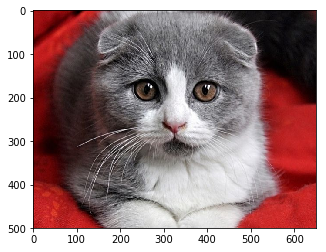

In [23]:
# Test own image
my_image='isacatornot.jpg'

fname='images/'+my_image
image=plt.imread(fname)
# 下面这段代码即将淘汰
# my_image=scipy.misc.imresize(image,size=(num_px,num_px)).reshape((1,num_px*num_px*3)).T
my_image=resize(image,(num_px,num_px),mode='reflect').reshape((num_px*num_px*3,1))
my_predicted_image=predict(d['w'],d['b'],my_image)
plt.imshow(image)
print('y='+str(np.squeeze(my_predicted_image))+',your algorithm predicts a \"'+classes[int(np.squeeze(my_predicted_image)),].decode('utf-8')+'\" picture.')

In [24]:
# 上面的一些数据
image.shape

(500, 650, 3)

In [25]:
type(image)

numpy.ndarray

In [26]:
my_image.shape

(12288, 1)

In [27]:
d['w']

array([[ 0.00961402],
       [-0.0264683 ],
       [-0.01226513],
       ...,
       [-0.01144453],
       [-0.02944783],
       [ 0.02378106]])

In [28]:
# 推荐如此操作图片
resize(image,(64,64),mode='reflect').shape

(64, 64, 3)

In [29]:
resize(image,(64,64),mode='reflect').reshape((64*64*3,1)).shape

(12288, 1)

In [30]:
my_predicted_image

array([[1.]])

In [31]:
np.squeeze(my_predicted_image)  # 用来压缩维度

array(1.)

In [32]:
type(my_predicted_image)

numpy.ndarray

In [33]:
type(np.squeeze(my_predicted_image))

numpy.ndarray